# ANN- Multivariate Time Series Solar Radiation(GHI) Forecasting with MLP, CNN, and LSTM Networks

#  MLP

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Imported mean_absolute_error

# Load and preprocess the dataset
#dataset = pd.read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset = pd.read_csv('jordan_pv.csv',  index_col='date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()
dataset = dataset.dropna()
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]
            names.append(target_col_name + '(t)')
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X, train_y = torch.Tensor(train_X), torch.Tensor(train_y).view(-1, 1)
test_X, test_y = torch.Tensor(test_X), torch.Tensor(test_y).view(-1, 1)

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, neurons, layers1, activation, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, neurons))
        self.layers.append(getattr(nn, activation)())
        for _ in range(layers1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(getattr(nn, activation)())
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.layers.append(nn.Linear(neurons, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to count the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Parameters
activation = 'ReLU'
batch_size = 64
dropout_rate = 0.05
epochs = 60
layers1 = 2
learning_rate = 0.001
neurons = 32
input_dim = train_X.shape[1]

# Prepare the data
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_dim, neurons, layers1, activation, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print trainable parameters
print(f"Trainable parameters: {count_parameters(model)}")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_X, val_y in test_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            val_loss += criterion(val_outputs, val_y).item()
        val_loss /= len(test_loader)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}')
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_nRMSE=np.sqrt(min_val_loss)
# Print the minimum validation loss
print(f"Minimum Validation Loss: {min_val_loss:.6f}")
print(f"Minimum Validation Loss nRMSE: {min_val_loss_nRMSE:.6f}")
# Make predictions
model.eval()
with torch.no_grad():
    train_predictions = model(train_X.to(device)).cpu().numpy()
    test_predictions = model(test_X.to(device)).cpu().numpy()

# Inverse transform the predictions and actual values
train_predict_inv = target_scaler.inverse_transform(train_predictions)
test_predict_inv = target_scaler.inverse_transform(test_predictions)
train_y_inv = target_scaler.inverse_transform(train_y.cpu().numpy().reshape(-1, 1))
test_y_inv = target_scaler.inverse_transform(test_y.cpu().numpy().reshape(-1, 1))

# Print the predicted and actual values for the first 5 items
for i in range(5):
    print('Train - Predicted:', train_predict_inv[i], 'Actual:', train_y_inv[i])
    print('Test - Predicted:', test_predict_inv[i], 'Actual:', test_y_inv[i])

# Calculate and print the MSE, RMSE, and MAE
train_mse = mean_squared_error(train_y_inv, train_predict_inv)
test_mse = mean_squared_error(test_y_inv, test_predict_inv)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(train_y_inv, train_predict_inv)
test_mae = mean_absolute_error(test_y_inv, test_predict_inv)

print("Train MSE: {:.6f}".format(train_mse))
print("Test MSE: {:.6f}".format(test_mse))
print("Train RMSE: {:.6f}".format(train_rmse))
print("Test RMSE: {:.6f}".format(test_rmse))
print("Train MAE: {:.6f}".format(train_mae))
print("Test MAE: {:.6f}".format(test_mae))


C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_15084\3043929999.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset.index = pd.to_datetime(dataset.index)


Trainable parameters: 2753
layers.0.weight: 576 parameters
layers.0.bias: 32 parameters
layers.2.weight: 1024 parameters
layers.2.bias: 32 parameters
layers.5.weight: 1024 parameters
layers.5.bias: 32 parameters
layers.8.weight: 32 parameters
layers.8.bias: 1 parameters
Epoch 1/60, Loss: 0.002472, Val Loss: 0.001823
Epoch 2/60, Loss: 0.006174, Val Loss: 0.001035
Epoch 3/60, Loss: 0.002706, Val Loss: 0.001013
Epoch 4/60, Loss: 0.003388, Val Loss: 0.000860
Epoch 5/60, Loss: 0.002232, Val Loss: 0.001028
Epoch 6/60, Loss: 0.001860, Val Loss: 0.000631
Epoch 7/60, Loss: 0.001803, Val Loss: 0.000537
Epoch 8/60, Loss: 0.002000, Val Loss: 0.001402
Epoch 9/60, Loss: 0.002763, Val Loss: 0.000786
Epoch 10/60, Loss: 0.001758, Val Loss: 0.000494
Epoch 11/60, Loss: 0.002415, Val Loss: 0.000641
Epoch 12/60, Loss: 0.003173, Val Loss: 0.000525
Epoch 13/60, Loss: 0.001892, Val Loss: 0.000696
Epoch 14/60, Loss: 0.001093, Val Loss: 0.000411
Epoch 15/60, Loss: 0.001290, Val Loss: 0.000914
Epoch 16/60, Loss:

In [2]:
print(model)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


#  CNN

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_17032\2058398237.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = pd.read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


Trainable parameters: 21729
conv1.weight: 32 parameters
conv1.bias: 32 parameters
conv2.weight: 1024 parameters
conv2.bias: 32 parameters
layers.0.weight: 18432 parameters
layers.0.bias: 32 parameters
layers.2.weight: 1024 parameters
layers.2.bias: 32 parameters
layers.5.weight: 1024 parameters
layers.5.bias: 32 parameters
output_layer.weight: 32 parameters
output_layer.bias: 1 parameters
Epoch 1/60, Loss: 0.003233, Val Loss: 0.001128
Epoch 2/60, Loss: 0.003051, Val Loss: 0.001333
Epoch 3/60, Loss: 0.001223, Val Loss: 0.000842
Epoch 4/60, Loss: 0.004021, Val Loss: 0.000663
Epoch 5/60, Loss: 0.003489, Val Loss: 0.000752
Epoch 6/60, Loss: 0.002616, Val Loss: 0.001097
Epoch 7/60, Loss: 0.001757, Val Loss: 0.001164
Epoch 8/60, Loss: 0.003079, Val Loss: 0.000536
Epoch 9/60, Loss: 0.001698, Val Loss: 0.000413
Epoch 10/60, Loss: 0.001463, Val Loss: 0.001576
Epoch 11/60, Loss: 0.000677, Val Loss: 0.000761
Epoch 12/60, Loss: 0.000834, Val Loss: 0.000884
Epoch 13/60, Loss: 0.001739, Val Loss: 0.

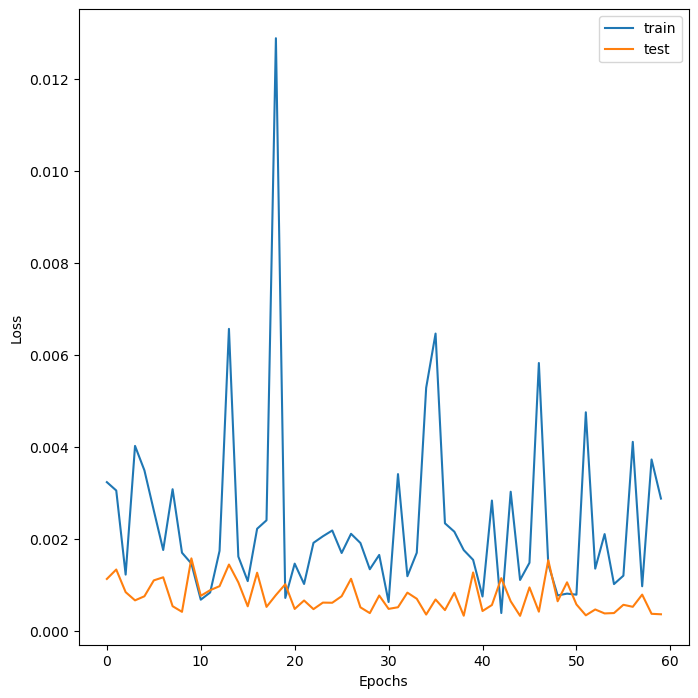

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Imported mean_absolute_error

# Load and preprocess the dataset
dataset = pd.read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = pd.read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()
dataset = dataset.dropna()
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]
            names.append(target_col_name + '(t)')
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X, train_y = torch.tensor(train_X).float(), torch.tensor(train_y).view(-1, 1).float()
test_X, test_y = torch.tensor(test_X).float(), torch.tensor(test_y).view(-1, 1).float()

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, neurons, layers1, activation, dropout_rate):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=1)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=1)
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim * 32, neurons))
        self.layers.append(getattr(nn, activation)())
        for _ in range(layers1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(getattr(nn, activation)())
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.output_layer = nn.Linear(neurons, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Function to count the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Parameters
activation = 'ReLU'
batch_size = 64
dropout_rate = 0.05
epochs = 60
layers1 = 2
learning_rate = 0.001
neurons = 32
input_dim = train_X.shape[1]

# Prepare the data
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_dim, neurons, layers1, activation, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print trainable parameters
print(f"Trainable parameters: {count_parameters(model)}")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []
min_val_loss = float('inf')
start_time = time.time()
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_X, val_y in test_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            val_loss += criterion(val_outputs, val_y).item()
    val_loss /= len(test_loader)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}')
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_nRMSE=np.sqrt(min_val_loss)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"The training process took {elapsed_time:.2f} seconds.")

# Print the minimum validation loss
print(f"Minimum Validation Loss: {min_val_loss:.6f}")
print(f"Minimum Validation Loss nRMSE: {min_val_loss_nRMSE:.6f}")

# Make predictions
model.eval()
with torch.no_grad():
    train_predictions = model(train_X.to(device)).cpu().numpy()
    test_predictions = model(test_X.to(device)).cpu().numpy()

# Inverse transform the predictions and actual values
train_predict_inv = target_scaler.inverse_transform(train_predictions)
test_predict_inv = target_scaler.inverse_transform(test_predictions)
train_y_inv = target_scaler.inverse_transform(train_y.cpu().numpy())
test_y_inv = target_scaler.inverse_transform(test_y.cpu().numpy())

# Print the predicted and actual values for the first 5 items
for i in range(5):
    print(f'Train - Predicted: {train_predict_inv[i][0]:.6f}, Actual: {train_y_inv[i][0]:.6f}')
    print(f'Test - Predicted: {test_predict_inv[i][0]:.6f}, Actual: {test_y_inv[i][0]:.6f}')

# Calculate and print the MSE, RMSE, and MAE
train_mse = mean_squared_error(train_y_inv, train_predict_inv)
test_mse = mean_squared_error(test_y_inv, test_predict_inv)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(train_y_inv, train_predict_inv)
test_mae = mean_absolute_error(test_y_inv, test_predict_inv)

print("Train MSE: {:.6f}".format(train_mse))
print("Test MSE: {:.6f}".format(test_mse))
print("Train RMSE: {:.6f}".format(train_rmse))
print("Test RMSE: {:.6f}".format(test_rmse))
print("Train MAE: {:.6f}".format(train_mae))
print("Test MAE: {:.6f}".format(test_mae))


In [14]:
print(model)

NeuralNetwork(
  (conv1): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): ModuleList(
    (0): Linear(in_features=576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
)


# LSTM

C:\Users\bahgat.ayasi\AppData\Local\Temp\ipykernel_17032\2986102517.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset = pd.read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')


Trainable parameters: 8801
lstm.weight_ih_l0: 2304 parameters
lstm.weight_hh_l0: 4096 parameters
lstm.bias_ih_l0: 128 parameters
lstm.bias_hh_l0: 128 parameters
layers.0.weight: 1024 parameters
layers.0.bias: 32 parameters
layers.2.weight: 1024 parameters
layers.2.bias: 32 parameters
output_layer.weight: 32 parameters
output_layer.bias: 1 parameters
Epoch 1/60, Loss: 0.008658, Val Loss: 0.001601
Epoch 2/60, Loss: 0.001849, Val Loss: 0.001039
Epoch 3/60, Loss: 0.006275, Val Loss: 0.000900
Epoch 4/60, Loss: 0.001652, Val Loss: 0.000899
Epoch 5/60, Loss: 0.003800, Val Loss: 0.000681
Epoch 6/60, Loss: 0.002129, Val Loss: 0.000744
Epoch 7/60, Loss: 0.000632, Val Loss: 0.000776
Epoch 8/60, Loss: 0.001918, Val Loss: 0.000478
Epoch 9/60, Loss: 0.001165, Val Loss: 0.000456
Epoch 10/60, Loss: 0.001359, Val Loss: 0.000664
Epoch 11/60, Loss: 0.002189, Val Loss: 0.000458
Epoch 12/60, Loss: 0.001651, Val Loss: 0.000444
Epoch 13/60, Loss: 0.002955, Val Loss: 0.000476
Epoch 14/60, Loss: 0.001619, Val 

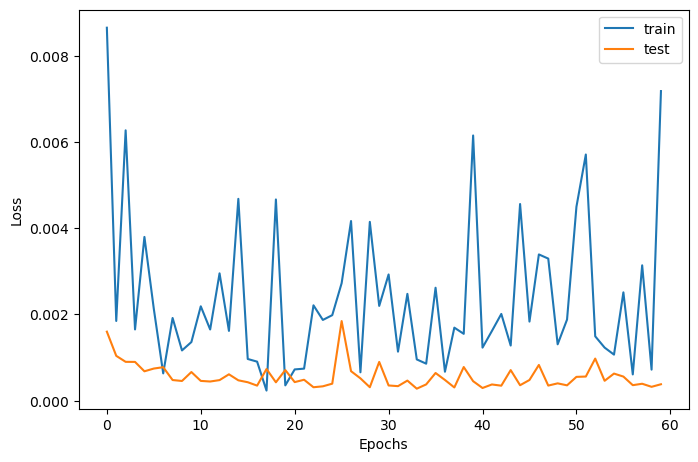

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Imported mean_absolute_error

# Load and preprocess the dataset
dataset = pd.read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
#dataset = pd.read_csv('Palestine-PV.csv', parse_dates=['date'], index_col='date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()
dataset = dataset.dropna()
dataset = dataset.astype(np.float64)

def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]
            names.append(target_col_name + '(t)')
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)', 3, 1)
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X, train_y = torch.tensor(train_X).float(), torch.tensor(train_y).view(-1, 1).float()
test_X, test_y = torch.tensor(test_X).float(), torch.tensor(test_y).view(-1, 1).float()

# Define the LSTM model
class LSTMNetwork(nn.Module):
    def __init__(self, input_dim, neurons, layers1, activation, dropout_rate):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(18, neurons, batch_first=True)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(neurons, neurons))
        self.layers.append(getattr(nn, activation)())
        for _ in range(layers1 - 1):
            self.layers.append(nn.Linear(neurons, neurons))
            self.layers.append(getattr(nn, activation)())
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.output_layer = nn.Linear(neurons, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # get the last output of the sequence
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Function to count the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Parameters
activation = 'ReLU'
batch_size = 64
dropout_rate = 0.05
epochs = 60
layers1 = 2
learning_rate = 0.001
neurons = 32
#input_dim = train_X.shape[2]  # Updated for LSTM input

# Prepare the data
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMNetwork(input_dim, neurons, layers1, activation, dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Print trainable parameters
print(f"Trainable parameters: {count_parameters(model)}")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_X, val_y in test_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            val_loss += criterion(val_outputs, val_y).item()
    val_loss /= len(test_loader)
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}')
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_nRMSE=np.sqrt(min_val_loss)

# Print the minimum validation loss
print(f"Minimum Validation Loss: {min_val_loss:.6f}")
print(f"Minimum Validation Loss nRMSE: {min_val_loss_nRMSE:.6f}")
# Make predictions
model.eval()
with torch.no_grad():
    train_predictions = model(train_X.to(device)).cpu().numpy()
    test_predictions = model(test_X.to(device)).cpu().numpy()

# Inverse transform the predictions and actual values
train_predict_inv = target_scaler.inverse_transform(train_predictions)
test_predict_inv = target_scaler.inverse_transform(test_predictions)
train_y_inv = target_scaler.inverse_transform(train_y.cpu().numpy())
test_y_inv = target_scaler.inverse_transform(test_y.cpu().numpy())

# Print the predicted and actual values for the first 5 items
for i in range(5):
    print(f'Train - Predicted: {train_predict_inv[i][0]:.6f}, Actual: {train_y_inv[i][0]:.6f}')
    print(f'Test - Predicted: {test_predict_inv[i][0]:.6f}, Actual: {test_y_inv[i][0]:.6f}')

# Calculate and print the MSE, RMSE, and MAE
train_mse = mean_squared_error(train_y_inv, train_predict_inv)
test_mse = mean_squared_error(test_y_inv, test_predict_inv)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(train_y_inv, train_predict_inv)
test_mae = mean_absolute_error(test_y_inv, test_predict_inv)

print("Train MSE: {:.6f}".format(train_mse))
print("Test MSE: {:.6f}".format(test_mse))
print("Train RMSE: {:.6f}".format(train_rmse))
print("Test RMSE: {:.6f}".format(test_rmse))
print("Train MAE: {:.6f}".format(train_mae))
print("Test MAE: {:.6f}".format(test_mae))


In [29]:
print(model)

LSTMNetwork(
  (lstm): LSTM(60, 32, batch_first=True)
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
